In [265]:
from databaseconnection import DatabaseConnection
gds = DatabaseConnection().get_database_connection()
gds.version()

Failed to write data to connection ResolvedIPv4Address(('127.0.0.1', 7687)) (IPv4Address(('127.0.0.1', 7687)))
Failed to write data to connection IPv4Address(('localhost', 7687)) (IPv4Address(('127.0.0.1', 7687)))


'2.3.2'

In [125]:
id = 14662
is_positive = 0
gds.run_cypher(f"MATCH (q:Question) WHERE id(q) = {id} SET q.is_positive = {is_positive}")

""


## Fixat så att position är konsekvent för QuestionAlternative

In [13]:
result = gds.run_cypher("""
MATCH (qa:QuestionAlternative)<-[:CONSISTS_OF]-(q:Question)
WHERE (q.questionCategories = ["SCHOOL_CLIMATE"] OR q.questionCategories = ["STUDENT_SCHOOL_CLIMATE"] OR q.questionCategories = ["VICTIMIZATION"] OR q.questionCategories = ["STUDENT_VICTIMIZATION"]) AND q.questionType <> "FREE_TEXT" AND NOT qa.name IN ["Jag förstår inte frågan", "Vet inte / Kan inte svara"]
RETURN q.is_positive AS is_positive, id(q) AS id, q.name, qa.name, qa.position ORDER BY q.name, qa.position
""")
for index, row in result.iterrows():
    if row["qa.position"] == 0 and row["is_positive"] == 0:
        print(row["is_positive"], row["id"], row["qa.position"], row["qa.name"], row["q.name"])

0 13625 0 Nej, det har inte hänt mig A.	Tänk på hur du har haft det i skolan och på väg till och från skolan de senaste 2-3 månaderna.  Har du känt dig ledsen, sårad, rädd eller arg, av att andra ELEVER har slagit, sparkat, knuffat, hållit fast, stängt in dig eller hotat dig med vapen?
0 7205 0 Nej, det har inte hänt mig A. Jag har under de senaste 2-3 månaderna upplevt obehag (känt mig ledsen, sårad, rädd eller arg) av att andra ELEVER har slagit, sparkat, knuffat, hållit fast, låst in eller stängt in mig i SKOLAN, på skolgården eller på väg till/från skolan
0 7221 0 Nej, det har inte hänt mig B. Jag har du under de senaste 2-3 månaderna upplevt obehag (känt mig ledsen, sårad, rädd eller arg) av att andra ELEVER har retat, kallat mig elaka saker eller hotat mig i SKOLAN, på skolgården eller på väg till/från skolan
0 13631 0 Nej, det har inte hänt mig B. Tänk på hur du har haft det i skolan och på väg till och från skolan de senaste 2-3 månaderna . Har du känt dig ledsen, sårad, rädd e

In [115]:
q_id = 13666
gds.run_cypher(f"""
MATCH (q:Question)-[:CONSISTS_OF]->(qa:QuestionAlternative)
WHERE id(q) = {q_id}
RETURN q.name, id(qa), qa.name, qa.position ORDER BY qa.position
""")

,q.name,id(qa),qa.name,qa.position
0,Vi menar att en elev blir mobbad då en annan e...,13667,"Nej, det har inte hänt mig",0
1,Vi menar att en elev blir mobbad då en annan e...,13668,"Ja, någon gång",1
2,Vi menar att en elev blir mobbad då en annan e...,13669,"Ja, ett par gånger i månaden",2
3,Vi menar att en elev blir mobbad då en annan e...,13670,"Ja, ett par gånger i veckan eller oftare",3
4,Vi menar att en elev blir mobbad då en annan e...,13671,Jag förstår inte frågan,4


In [121]:
gds.run_cypher(f"""
MATCH (q:Question)-[:CONSISTS_OF]->(qa:QuestionAlternative)
WHERE id(q) = {q_id}
RETURN q.name, id(qa), qa.name, qa.position ORDER BY qa.position
""")

,q.name,id(qa),qa.name,qa.position
0,Vi menar att en elev blir mobbad då en annan e...,13670,"Ja, ett par gånger i veckan eller oftare",0
1,Vi menar att en elev blir mobbad då en annan e...,13669,"Ja, ett par gånger i månaden",1
2,Vi menar att en elev blir mobbad då en annan e...,13668,"Ja, någon gång",2
3,Vi menar att en elev blir mobbad då en annan e...,13667,"Nej, det har inte hänt mig",3
4,Vi menar att en elev blir mobbad då en annan e...,13671,Jag förstår inte frågan,4


In [120]:
qa_id = 13670
new_position = 0
gds.run_cypher(f"""
MATCH (qa:QuestionAlternative) WHERE id(qa) = {qa_id} SET qa.position = {new_position}
""")

""


## Beräkna positivitetsIndex

In [ ]:
result = gds.run_cypher(f"""
MATCH (s:Student)-[:HAS_ANSWERED]->(a:Answer)-[:IS_ANSWER_TO]->(q:Question)-[:CONSISTS_OF]->(qa:QuestionAlternative)
WHERE (q.questionCategories = ["SCHOOL_CLIMATE"] OR q.questionCategories = ["STUDENT_SCHOOL_CLIMATE"] OR q.questionCategories = ["VICTIMIZATION"] OR q.questionCategories = ["STUDENT_VICTIMIZATION"]) AND q.questionType <> "FREE_TEXT" AND NOT qa.name IN ["Jag förstår inte frågan", "Vet inte / Kan inte svara"]
WITH s, q, q.is_positive AS is_positive, qa.position AS position
MATCH (q)-[:CONSISTS_OF]->(all_qa:QuestionAlternative)
WITH s, is_positive, position, COUNT(all_qa) - 1 AS total_positions
WITH s, is_positive, position, total_positions, toFloat(position) / total_positions AS normalized_position
WITH s, (CASE is_positive
          WHEN 1 THEN normalized_position
          ELSE 1 - normalized_position
        END) AS score
WITH id(s) AS StudentId, AVG(score) AS AvgScore
RETURN StudentId, AvgScore
ORDER BY AvgScore DESC
""")
for index, row in result.iterrows():
    print(row['StudentId'], row['AvgScore'])

In [156]:
result = gds.run_cypher(f"""
  MATCH (s:Student)-[:CHOSE_ALT]->(qa:QuestionAlternative)<-[:CONSISTS_OF]-(q:Question)
  WHERE (q.questionCategories = ["SCHOOL_CLIMATE"] OR q.questionCategories = ["STUDENT_SCHOOL_CLIMATE"] OR q.questionCategories = ["VICTIMIZATION"] OR q.questionCategories = ["STUDENT_VICTIMIZATION"]) AND q.questionType = "SINGLE_CHOICE" AND NOT qa.name IN ["Jag förstår inte frågan", "Jag förstår inte frågan ", "Vet inte / Kan inte svara", "Vet inte/Kan inte svara"]
  WITH s, q, q.is_positive AS is_positive, qa.position AS position
  MATCH (q)-[:CONSISTS_OF]->(all_qa:QuestionAlternative)
  WITH s, q, is_positive, position, collect(all_qa) AS all_qa
  WITH s, is_positive, position, size([qa IN all_qa WHERE NOT qa.name IN ["Jag förstår inte frågan", "Jag förstår inte frågan ", "Vet inte / Kan inte svara", "Vet inte/Kan inte svara"]]) - 1 AS total_positions
  WITH s, is_positive, position, total_positions, toFloat(position) / total_positions AS normalized_position
  WITH s, (CASE is_positive
              WHEN 1 THEN 1 - normalized_position
              ELSE normalized_position
            END) AS score
  WITH s, AVG(score) AS PositivityIndex
  SET s.positivityIndex = PositivityIndex
  RETURN id(s) AS StudentId, s.positivityIndex
  ORDER BY s.positivityIndex DESC
""")

for index, row in result.iterrows():
    # if row['StudentId'] ==  53885.0:
    print(row['StudentId'], row['s.positivityIndex'], sep='  \t')

152532.0  	1.0
178075.0  	1.0
35088.0  	1.0
94563.0  	1.0
161928.0  	1.0
152596.0  	1.0
163147.0  	1.0
198290.0  	1.0
230570.0  	1.0
154201.0  	1.0
200345.0  	1.0
30593.0  	1.0
105660.0  	1.0
112948.0  	1.0
192056.0  	1.0
209711.0  	1.0
27204.0  	1.0
93866.0  	1.0
149901.0  	1.0
131715.0  	1.0
189860.0  	1.0
154393.0  	1.0
118317.0  	1.0
107665.0  	1.0
65590.0  	1.0
158286.0  	1.0
34153.0  	1.0
107472.0  	1.0
81441.0  	1.0
158862.0  	1.0
166341.0  	1.0
158094.0  	1.0
159118.0  	1.0
127471.0  	1.0
173468.0  	1.0
180577.0  	1.0
31111.0  	1.0
158734.0  	1.0
180514.0  	1.0
129014.0  	1.0
155998.0  	1.0
200474.0  	1.0
158670.0  	1.0
54521.0  	1.0
161609.0  	1.0
152467.0  	1.0
109851.0  	1.0
173596.0  	1.0
199831.0  	1.0
73544.0  	0.99375
85012.0  	0.9925925925925926
94626.0  	0.9924242424242424
188135.0  	0.9914529914529914
95132.0  	0.9851851851851853
86211.0  	0.9851851851851852
53061.0  	0.985185185185185
60159.0  	0.985185185185185
68878.0  	0.984848484848485
73860.0  	0.984848484848485

In [264]:
gds.run_cypher(f"""
MATCH (s:Student)
WHERE s.positivityIndex IS NOT NULL
RETURN id(s) AS StudentId, s.positivityIndex AS positivityIndex
""")

,StudentId,positivityIndex
0,7483,0.858156
1,7771,0.738095
2,7829,0.652778
3,7894,0.763889
4,7957,0.055556
...,...,...
2988,231975,0.631481
2989,232039,0.587209
2990,232103,0.509259
2991,232167,0.891473


In [205]:
import math

students_positivity_results = gds.run_cypher(f"""
MATCH (s:Student)
WHERE s.positivityIndex IS NOT NULL
RETURN id(s) AS StudentId, s.schoolClimateNormalityIndex AS schoolClimateNormalityIndex, s.victimizationNormalityIndex AS victimizationNormalityIndex, s.positivityIndex AS positivityIndex, s.louvainId_similarity_pos_prop AS louvainId_similarity_pos_prop
ORDER BY s.positivityIndex
""")

In [206]:
bottom_percent = math.ceil(students_positivity_results.shape[0] * 0.08)
bottom_result = students_positivity_results.head(bottom_percent)

top_percent = math.ceil(students_positivity_results.shape[0] * 0.75)
top_result = students_positivity_results.tail(top_percent)

middle_result = students_positivity_results.iloc[bottom_percent:students_positivity_results.shape[0] - top_percent]
# middle_result
bottom_result

,StudentId,schoolClimateNormalityIndex,victimizationNormalityIndex,positivityIndex,louvainId_similarity_pos_prop
0,8020,0.075660,NaN,0.000000,46
1,163210,0.072250,0.056253,0.000000,2290
2,178845,0.093908,0.067472,0.000000,94
3,200602,0.063762,0.051585,0.000000,2290
4,7957,0.058246,0.066216,0.055556,46
...,...,...,...,...,...
235,164234,0.227328,0.364833,0.482906,1418
236,28921,0.249694,0.412919,0.482906,94
237,118760,0.251215,0.348056,0.483333,1418
238,127857,0.252886,0.618269,0.483333,94


C:\Users\olofe\AppData\Local\Temp\ipykernel_16160\3879321325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  splits[i]['split'] = i + 1
C:\Users\olofe\AppData\Local\Temp\ipykernel_16160\3879321325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  splits[i]['split'] = i + 1
C:\Users\olofe\AppData\Local\Temp\ipykernel_16160\3879321325.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

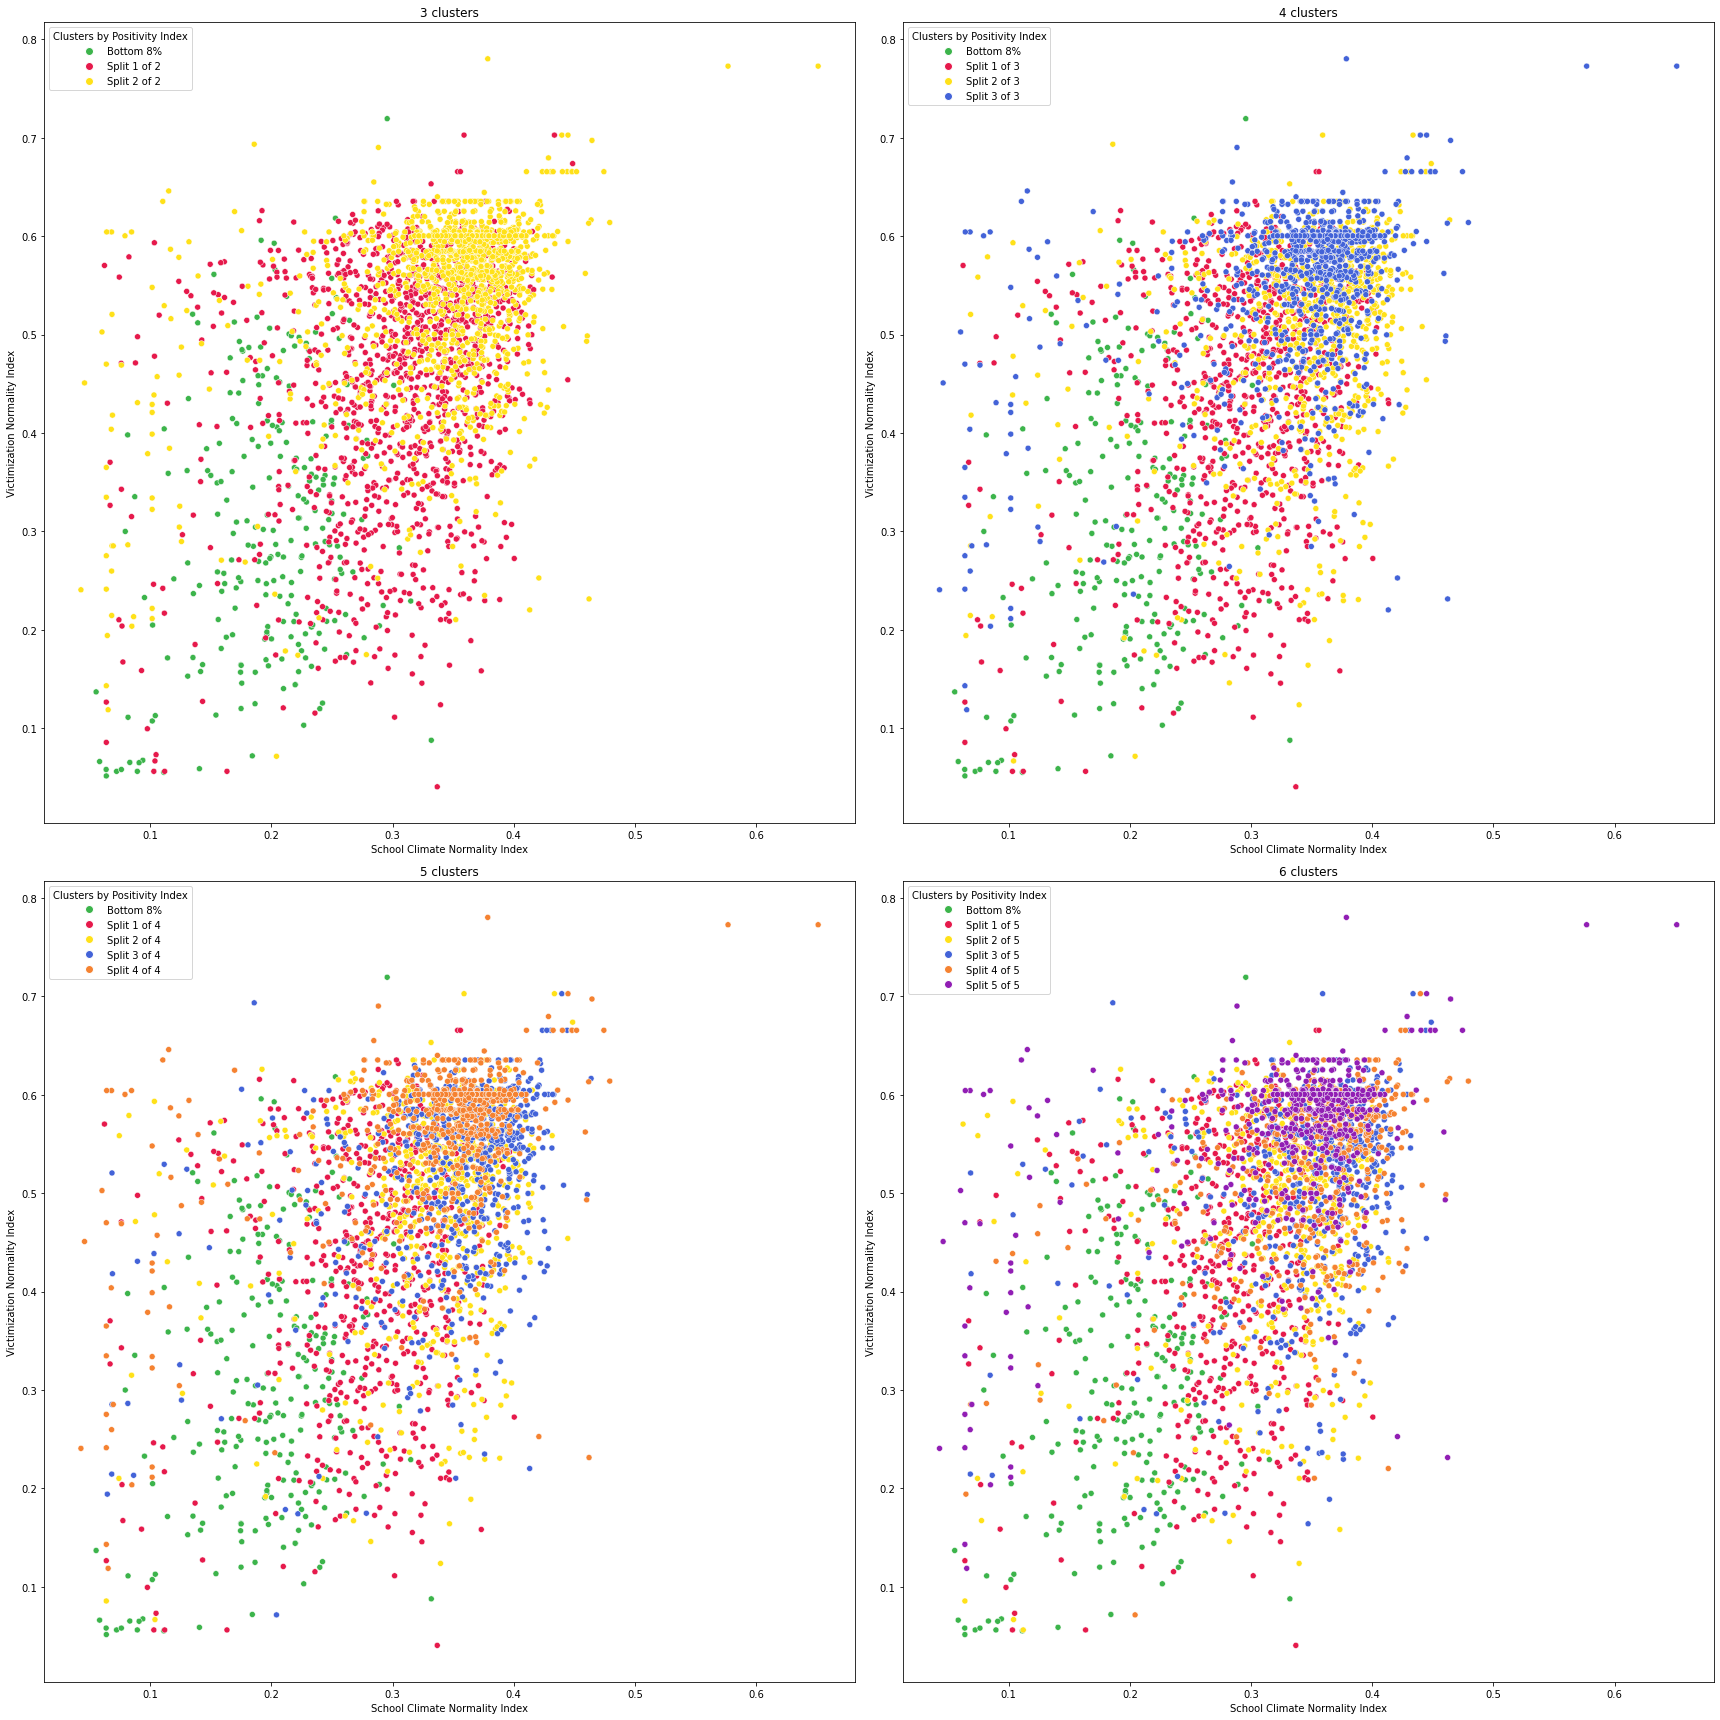

In [261]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom colors for each cluster ID
# cluster_colors = {
#     46: 'tab:blue',
#     712: 'tab:orange',
#     94: 'tab:green',
#     1418: 'tab:red',
#     2232: 'tab:purple',
#     1150: 'tab:brown',
#     2290: 'tab:pink',
#     2622: 'tab:gray'
# }
cluster_colors = [
    '#3cb44b',
    '#e6194B',
    '#ffe119',
    '#4363d8',
    '#f58231',
    '#911eb4',
    '#42d4f4',
]

bottom_percent = math.ceil(students_positivity_results.shape[0] * 0.08)
bottom_result = students_positivity_results.head(bottom_percent)
# bottom_result['color'] = '#e6194B'
rest = students_positivity_results.tail(students_positivity_results.shape[0] - bottom_percent)

fig, axes = plt.subplots(2, 2, figsize=(24, 24))
# fig.suptitle('School climate vs victimization normality index with positivity index clusters', fontsize=18, y=1.0)
for nr_of_splits in range(2, 6):
    split_points = np.linspace(0, len(rest), nr_of_splits + 1, dtype=int)
    splits = [rest.iloc[split_points[i]:split_points[i + 1]] for i in range(nr_of_splits)]
    for i in range(len(splits)):
        splits[i]['split'] = i + 1
    bottom_result['split'] = 0
    result = pd.concat([bottom_result] + splits).reset_index(drop=True)
    ax = axes[(nr_of_splits - 2) // 2, (nr_of_splits - 2) % 2]
    sns.scatterplot(ax=ax, data=result, x='schoolClimateNormalityIndex', y='victimizationNormalityIndex', hue='split', palette=cluster_colors[:nr_of_splits + 1])

    # Create custom legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Split {i} of {nr_of_splits}', markerfacecolor=color, markersize=8) for i, color in enumerate(cluster_colors[:nr_of_splits + 1])]
    legend_elements[0] = plt.Line2D([0], [0], marker='o', color='w', label=f'Bottom 8%', markerfacecolor=cluster_colors[0], markersize=8)
    ax.legend(handles=legend_elements, loc='upper left').set_title("Clusters by Positivity Index")

    ax.set_xlabel('School Climate Normality Index')
    ax.set_ylabel('Victimization Normality Index')
    ax.set_title(f'{nr_of_splits + 1} clusters')

plt.xlabel('School Climate Normality Index')
plt.ylabel('Victimization Normality Index')
fig.tight_layout()
plt.show()
# plt.title('Scatterplot of Victimization vs. School Climate Normality Index with Positivity Index Clusters')

In [269]:
students_positivity_results = gds.run_cypher(f"""
MATCH (s:Student)
WHERE s.positivityIndex IS NOT NULL
RETURN id(s) AS StudentId, s.positivityIndex AS positivityIndex, s.louvainId_similarity_pos_prop AS louvainId_similarity_pos_prop
ORDER BY s.positivityIndex
""")

bottom_percent = math.ceil(students_positivity_results.shape[0] * 0.08)
bottom_result = students_positivity_results.head(bottom_percent)

# Count the number of students in community 94
community_94 = students_positivity_results[students_positivity_results['louvainId_similarity_pos_prop'] == 94]
community_94.shape[0] / bottom_result.shape[0]

0.7833333333333333